In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Introduction

need to do

# Data

The dataset I chose to explore is the famous Titanic dataset.  The dataset can be found here, https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/problem12.html



In [2]:
df = pd.read_csv('titanic.csv')

In [3]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Siblings/Spouses Aboard',
       'Parents/Children Aboard', 'Fare'],
      dtype='object')

In [4]:
df.drop('Name', axis=1, inplace=True)

In [5]:
df.head()

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [6]:
df.isnull().sum()

Survived                   0
Pclass                     0
Sex                        0
Age                        0
Siblings/Spouses Aboard    0
Parents/Children Aboard    0
Fare                       0
dtype: int64

In [7]:
df = pd.get_dummies(df) # maybe instead of get dummies replace with 1 male -1 female

In [8]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [9]:
df.head()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male
0,0,3,22.0,1,0,7.2500,0,1
1,1,1,38.0,1,0,71.2833,1,0
2,1,3,26.0,0,0,7.9250,1,0
3,1,1,35.0,1,0,53.1000,1,0
4,0,3,35.0,0,0,8.0500,0,1


# Initial 2D view of the dataset using PCA and UMAP


In [10]:
#X_initial = StandardScaler().fit_transform(X)
X_initial = MinMaxScaler().fit_transform(X)

In [11]:
pca = PCA(n_components=2)

In [12]:
X_2d_pca = pca.fit_transform(X_initial)

<AxesSubplot:>

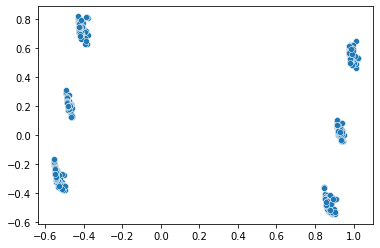

In [13]:
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1])

As PCA preserves distance, the image shows that there are definite clusters distanct from eachother.  Although nothing can be inferred, a cluster number of at least 6 seems reasonable.

In [14]:
umap2 = UMAP(n_components=2)

In [15]:
X_initial_2d = umap2.fit_transform(X_initial)

<AxesSubplot:>

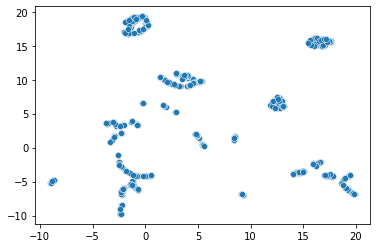

In [16]:
sns.scatterplot(x=X_initial_2d[:,0],y=X_initial_2d[:,1])

Although nothing can be inferred, there appear to be ten or more clusters.

In [17]:
df['x'] = X_initial_2d[:,0]
df['y'] = X_initial_2d[:,1]

# Clustering all data using KMeans

* use inertia to find the best k or k values
* Check consistency (will do this eventually when I pick the clustering method)
* Look at silhouette score

In [18]:
inertia_values = []
for n in range(2,21):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_initial)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))


<AxesSubplot:>

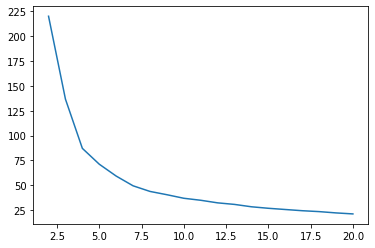

In [19]:
sns.lineplot(x=results[0],y=results[1])

It is hard to see an elbow.  I would say 4 or 6.

Checking for a more pronounced elbow by adjusting other parameters of the k means algorithm

<AxesSubplot:>

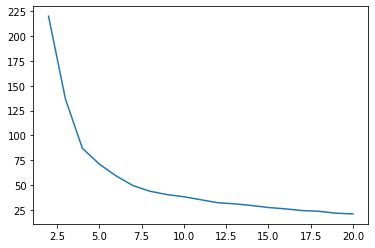

In [20]:
inertia_values = []
for n in range(2,21):
    kmeans = KMeans(n_clusters=n, algorithm='full')
    kmeans.fit(X_initial)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))
sns.lineplot(x=results[0],y=results[1])

<AxesSubplot:>

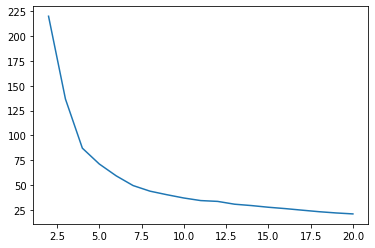

In [21]:
inertia_values = []
for n in range(2,21):
    kmeans = KMeans(n_clusters=n, algorithm='elkan')
    kmeans.fit(X_initial)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))
sns.lineplot(x=results[0],y=results[1])

The three graphs look similar.  I will choose 6 for kmeans

In [22]:
kmeans = KMeans(n_clusters=6)
#labels = kmeans.fit_predict(X_initial)
df['kmeans_labels'] = kmeans.fit_predict(X_initial)

Visualizing the data

<AxesSubplot:xlabel='x', ylabel='y'>

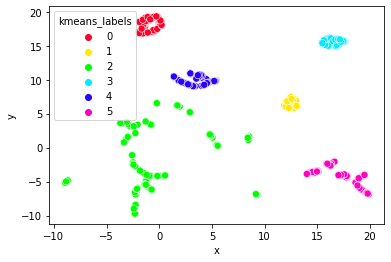

In [23]:
sns.scatterplot(x='x',y='y', hue='kmeans_labels', data=df, palette='gist_rainbow', s=50)
#sns.scatterplot(x=X_initial_2d[:,0],y=X_initial_2d[:,1], hue=labels, palette='gist_rainbow', s=50)

There does seem some mixing of clusters, going to get the silhouette score.

In [24]:
silhouette_score(X_initial, df['kmeans_labels'])

0.5276062174579387

A 0.5 silhouette_score is not bad.  Now I am going to check for consistency using visualizations.

# Hierarchal Clustering

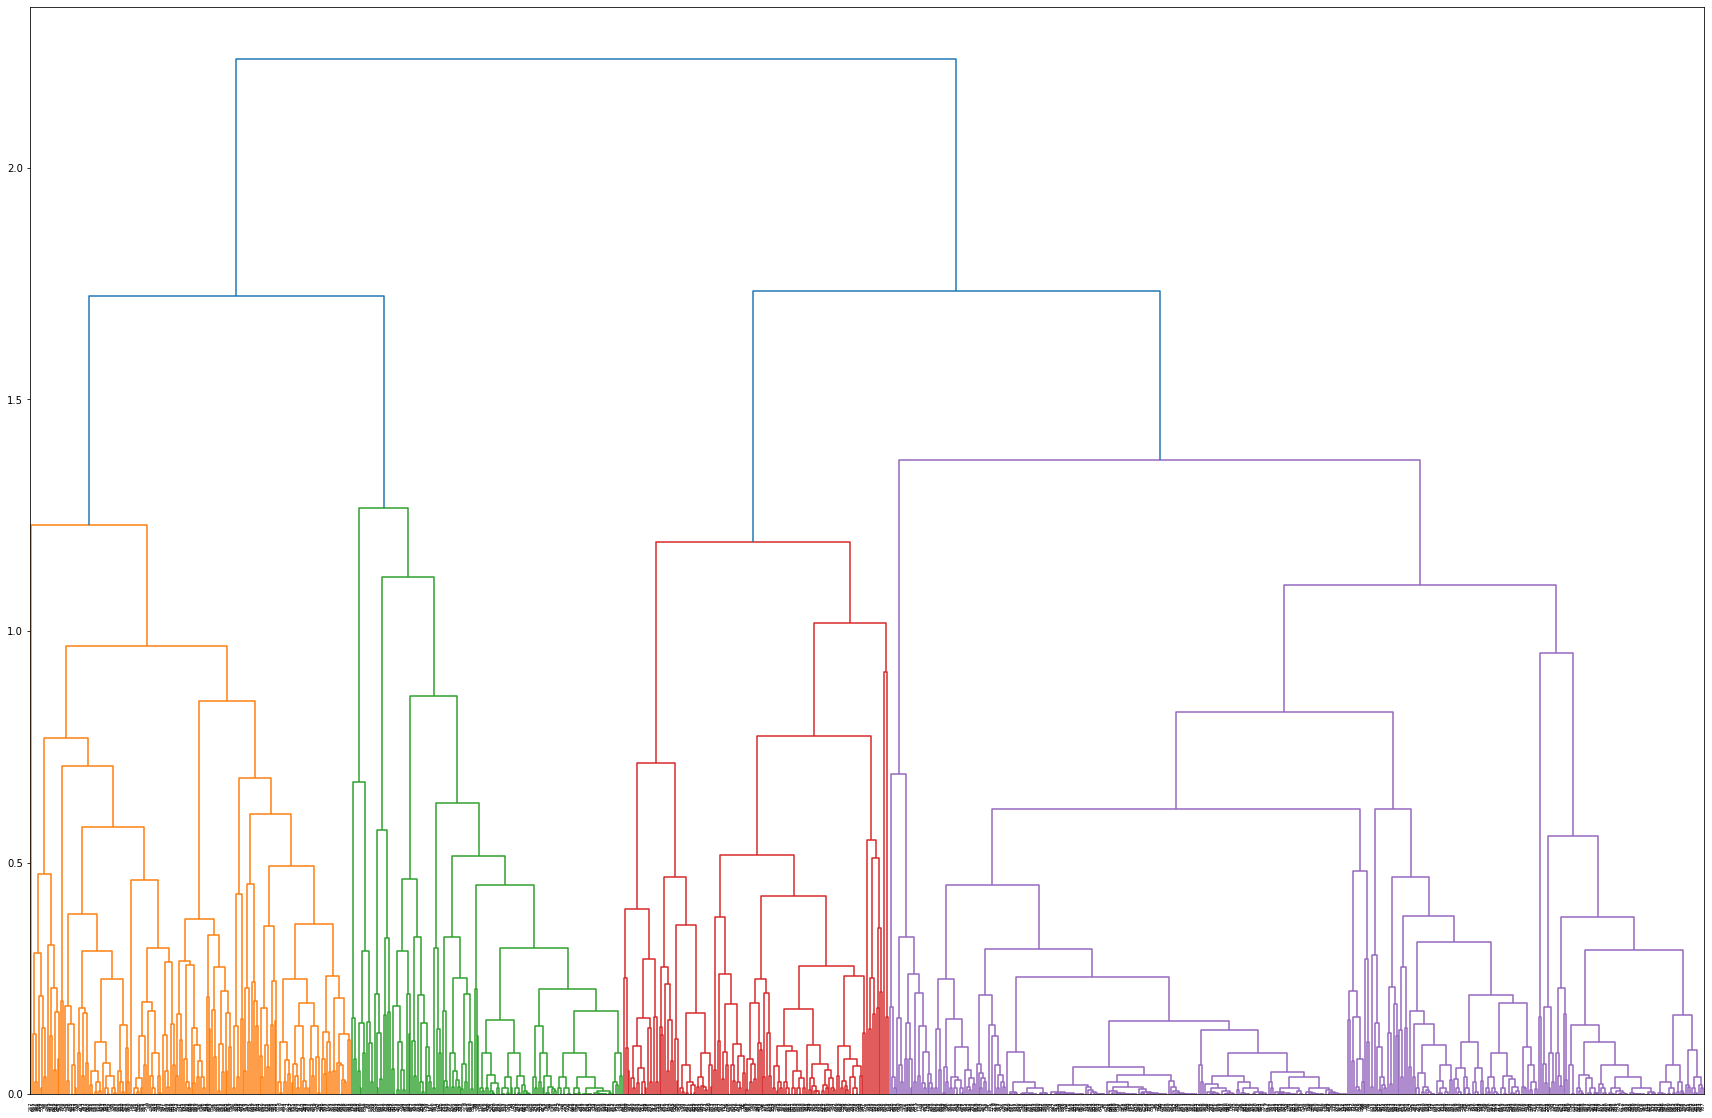

In [25]:
plt.figure(figsize=(30,20))
dendrogram(linkage(X_initial, method='complete'))
plt.show()

In order to incorporate all the various colors, you will want the number of clusters to be at least 10.

In [26]:
agg = AgglomerativeClustering(n_clusters=10)

In [27]:
agg.fit(X_initial)

AgglomerativeClustering(n_clusters=10)

In [28]:
df['agg_labels'] = agg.fit_predict(X_initial)

In [29]:
silhouette_score(X_initial, df['agg_labels'])

0.5054947804730059

In [42]:
# need to play more with this

# Clustering using DBSCAN

In [30]:
db = DBSCAN()

In [31]:
df['dbscan_labels']=db.fit_predict(X_initial)

In [32]:
# now get the silhouette score for those that are not outlers
silhouette_score(X_initial[df['dbscan_labels']!=-1],df[df['dbscan_labels']!=-1]['dbscan_labels'])

0.548950699002414

In [33]:
df['dbscan_labels'].max()

4

DBSCAN chose 4 clusters which the elbow method originally also suggested.

# Comparing clusters

In [34]:
stats = {}
for n in range(6):
    stats['mean_cluster_{}'.format(n)] = df[df['kmeans_labels']==n].mean()
    stats['std_cluster_{}'.format(n)] = df[df['kmeans_labels']==n].std()
(pd.DataFrame(stats)).transpose()
    

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male,x,y,kmeans_labels,agg_labels,dbscan_labels
mean_cluster_0,0.368852,1.0,41.511639,0.311475,0.278689,67.226127,0.0,1.0,-0.941808,18.127169,0.0,0.000000,2.934426
std_cluster_0,0.484484,0.0,14.324665,0.546695,0.658853,77.548021,0.0,0.0,0.736684,0.860549,0.0,0.000000,0.510027
mean_cluster_1,0.921053,2.0,28.980263,0.486842,0.605263,21.970121,1.0,0.0,12.547865,6.579432,1.0,5.000000,4.000000
std_cluster_1,0.271448,0.0,12.855723,0.642774,0.833930,10.891796,0.0,0.0,0.381429,0.549136,0.0,0.000000,0.000000
mean_cluster_2,0.137026,3.0,26.470612,0.504373,0.227405,12.695466,0.0,1.0,-0.338809,-1.688151,2.0,3.865889,0.000000
std_cluster_2,0.344377,0.0,11.843691,1.295227,0.626562,11.740102,0.0,0.0,4.394066,4.566246,0.0,1.780196,0.000000
mean_cluster_3,0.968085,1.0,35.255319,0.553191,0.457447,106.125798,1.0,0.0,16.454815,15.527910,3.0,2.000000,0.978723
std_cluster_3,0.176716,0.0,13.257529,0.665865,0.728305,74.259988,0.0,0.0,0.668940,0.373474,0.0,0.000000,0.206284
mean_cluster_4,0.157407,2.0,30.493796,0.342593,0.222222,19.741782,0.0,1.0,3.440180,9.962104,4.0,1.000000,0.000000
std_cluster_4,0.365882,0.0,14.382035,0.566380,0.517603,14.922235,0.0,0.0,1.213276,0.582311,0.0,0.000000,0.000000


In [35]:
stats2 = {}
for n in range(5):
    stats2['mean_cluster_{}'.format(n)] = df[df['dbscan_labels']==n].mean()
    stats2['std_cluster_{}'.format(n)] = df[df['dbscan_labels']==n].std()
(pd.DataFrame(stats2)).transpose()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male,x,y,kmeans_labels,agg_labels,dbscan_labels
mean_cluster_0,0.141907,2.760532,27.434035,0.465632,0.226164,14.382832,0.0,1.0,0.566137,1.101711,2.478936,3.179601,0.0
std_cluster_0,0.349342,0.427233,12.599386,1.164491,0.601722,12.913563,0.0,0.0,4.198880,6.379756,0.854465,1.976783,0.0
mean_cluster_1,0.967742,1.000000,35.258065,0.559140,0.462366,101.758019,1.0,0.0,16.455843,15.528177,3.000000,2.000000,1.0
std_cluster_1,0.177642,0.000000,13.329359,0.666959,0.730681,61.332784,0.0,0.0,0.672490,0.375489,0.000000,0.000000,0.0
mean_cluster_2,0.500000,3.000000,22.135417,0.895833,0.798611,16.118810,1.0,0.0,17.276873,-4.228742,5.000000,6.416667,2.0
std_cluster_2,0.501745,0.000000,12.181031,1.531573,1.237976,11.690314,0.0,0.0,1.916643,1.326377,0.000000,1.431416,0.0
mean_cluster_3,0.358333,1.000000,41.611833,0.316667,0.275000,59.807742,0.0,1.0,-0.936938,18.118940,0.000000,0.000000,3.0
std_cluster_3,0.481521,0.000000,14.423002,0.549764,0.660564,52.245363,0.0,0.0,0.741855,0.865344,0.000000,0.000000,0.0
mean_cluster_4,0.921053,2.000000,28.980263,0.486842,0.605263,21.970121,1.0,0.0,12.547865,6.579432,1.000000,5.000000,4.0
std_cluster_4,0.271448,0.000000,12.855723,0.642774,0.833930,10.891796,0.0,0.0,0.381429,0.549136,0.000000,0.000000,0.0


In [120]:
df[df['dbscan_labels']==0].Pclass.unique()

array([3], dtype=int64)

# Looking at what DBSCAN calls outliers

In [36]:
df[df['dbscan_labels']==-1]

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male,x,y,kmeans_labels,agg_labels,dbscan_labels
257,1,1,35.0,0,0,512.3292,1,0,16.359047,15.503055,3,2,-1
676,1,1,36.0,0,1,512.3292,0,1,-1.203098,18.605043,0,0,-1
733,1,1,35.0,0,0,512.3292,0,1,-1.264813,18.636923,0,0,-1
